<a href="https://colab.research.google.com/github/Tanish-Aravind/CODING-SAMURAI-INTERNSHIP-TASK/blob/main/CustomerChurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Class distribution:
 churn
1    0.8939
0    0.1061
Name: proportion, dtype: float64
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.8950

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.26      0.34       318
           1       0.92      0.97      0.94      2682

    accuracy                           0.90      3000
   macro avg       0.71      0.61      0.64      3000
weighted avg       0.87      0.90      0.88      3000



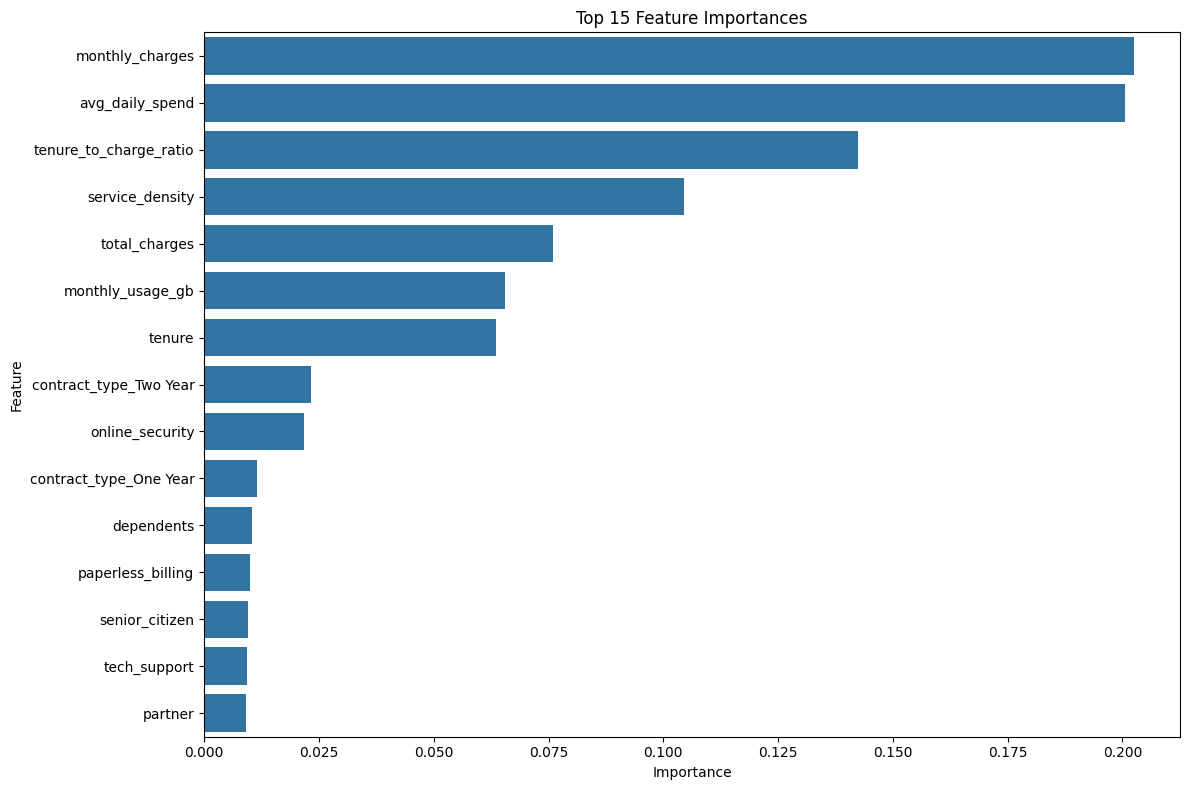

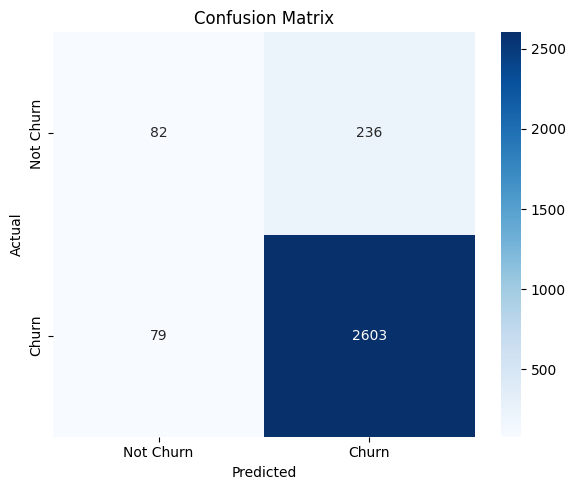

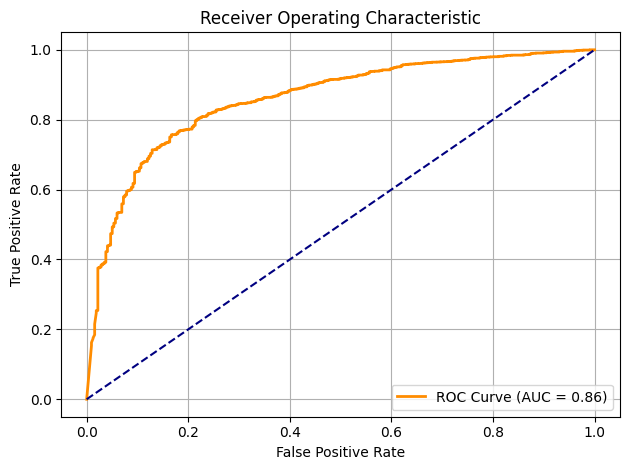

/tmp/ipython-input-3-149746519.py:143: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1], X_test, plot_type='bar')


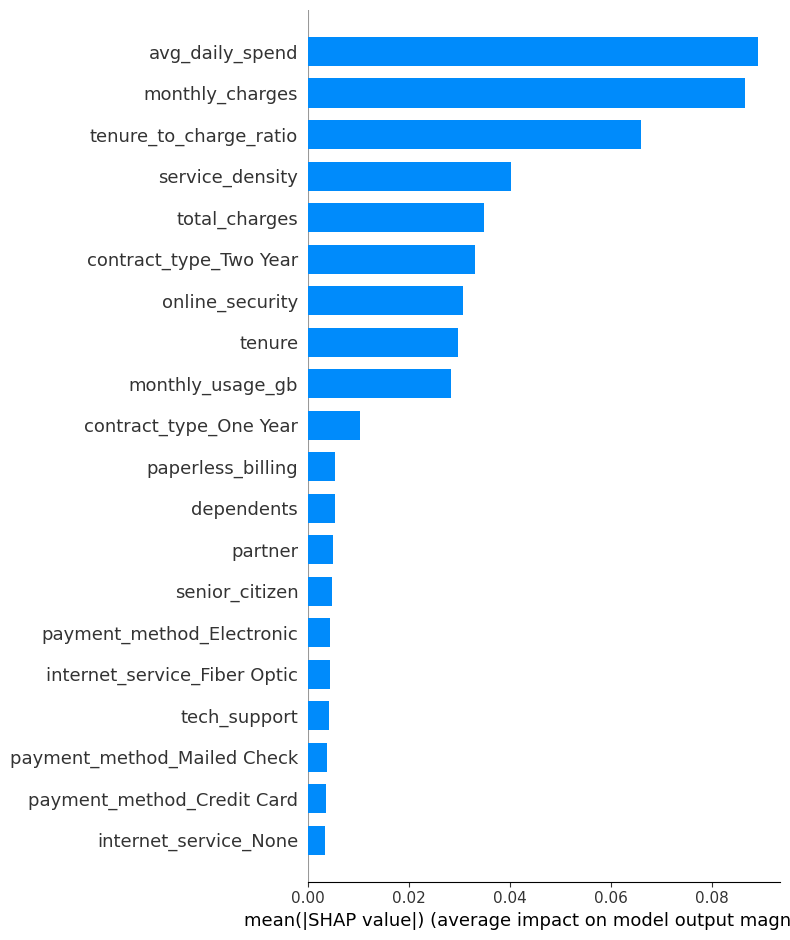

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

# Set random seed
np.random.seed(42)

# Generate synthetic customer churn dataset
n_samples = 10000
data = {
    'tenure': np.random.randint(1, 72, n_samples),
    'monthly_charges': np.round(np.random.uniform(20, 150, n_samples), 2),
    'total_charges': np.random.uniform(50, 10000, n_samples),
    'contract_type': np.random.choice(['Month-to-Month', 'One Year', 'Two Year'], n_samples, p=[0.5, 0.3, 0.2]),
    'paperless_billing': np.random.choice([0, 1], n_samples, p=[0.4, 0.6]),
    'payment_method': np.random.choice(['Electronic', 'Mailed Check', 'Bank Transfer', 'Credit Card'], n_samples),
    'senior_citizen': np.random.choice([0, 1], n_samples, p=[0.7, 0.3]),
    'dependents': np.random.choice([0, 1], n_samples, p=[0.6, 0.4]),
    'partner': np.random.choice([0, 1], n_samples, p=[0.55, 0.45]),
    'online_security': np.random.choice([0, 1], n_samples, p=[0.6, 0.4]),
    'tech_support': np.random.choice([0, 1], n_samples, p=[0.65, 0.35]),
    'internet_service': np.random.choice(['DSL', 'Fiber Optic', 'None'], n_samples, p=[0.4, 0.4, 0.2]),
    'monthly_usage_gb': np.random.randint(50, 1000, n_samples),
}

# Churn probability generation
log_odds = (
    -0.02 * data['tenure']
    + 0.05 * data['monthly_charges']
    - 0.0001 * data['total_charges']
    + np.where(data['contract_type'] == 'Month-to-Month', 0.8,
               np.where(data['contract_type'] == 'One Year', 0.2, -0.5))
    + np.where(data['online_security'] == 1, -0.6, 0.3)
)
prob_churn = 1 / (1 + np.exp(-log_odds))
data['churn'] = np.random.binomial(1, prob_churn)

df = pd.DataFrame(data)

# Feature engineering
df['avg_daily_spend'] = df['monthly_charges'] / 30
df['tenure_to_charge_ratio'] = df['tenure'] / df['monthly_charges']
df['service_density'] = df['monthly_usage_gb'] / df['monthly_charges']

# Encode categorical variables
df = pd.get_dummies(df, columns=['contract_type', 'payment_method', 'internet_service'], drop_first=True)

# Features and target
X = df.drop('churn', axis=1)
y = df['churn']

# Class balance check
print("Class distribution:\n", y.value_counts(normalize=True))

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Model and hyperparameter tuning using Stratified K-Fold
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
importances = best_model.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Churn', 'Churn'],
            yticklabels=['Not Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Save model
joblib.dump(best_model, 'rf_churn_model.pkl')

# SHAP explanation (optional but very insightful)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Select SHAP values for the positive class (index 1)
shap.summary_plot(shap_values[:, :, 1], X_test, plot_type='bar')
